# Introduction to the Monte Carlo Simulation Lab

This lab provides a complete, practical, and modular exploration of **Monte Carlo simulation**, one of the most powerful computational techniques for modeling uncertainty, estimating probabilities, and solving problems that lack closed-form analytical solutions. Monte Carlo methods are foundational across artificial intelligence, quantitative finance, physics, engineering, risk analysis, and scientific computing.

The purpose of this lab is to develop both **conceptual understanding** and **hands-on proficiency** by building a reusable simulation engine, running multiple classes of experiments, and analyzing results using statistical and graphical tools. Throughout the notebook, we demonstrate how random sampling can be used to approximate mathematical constants, evaluate financial and operational risk, model stochastic systems, and estimate the value of financial instruments.

The notebook includes several structured experiments, each highlighting a different aspect of Monte Carlo methodology:

### Estimating \( \pi \) using random sampling  
A classic geometric-sampling experiment showing how randomness can approximate a fundamental constant.

### Business risk and uncertainty modeling  
We simulate daily profit using a normal distribution to compute probabilities of loss and expected long-term performance.

### Option pricing with the Black–Scholes Monte Carlo model  
We simulate stock-price dynamics and estimate the fair value of a European call option using stochastic price paths.

### Confidence interval estimation  
We compute statistical bounds for Monte Carlo outputs, illustrating how uncertainty decreases with larger sample sizes.

### A modular Monte Carlo Engine  
We construct a reusable, object-oriented framework capable of running any stochastic model, computing summary statistics, and generating confidence intervals.

### Random walk visualization  
We simulate many stochastic trajectories to illustrate diffusion processes and uncertainty propagation, concepts central to physics, reinforcement learning, and quantitative modeling.

---

This lab is structured to help learners understand **how** Monte Carlo methods work and **why** they are essential for modeling uncertainty and approximating complex systems. Each experiment builds on the previous one, and the final framework serves as a foundation for advanced techniques such as importance sampling, variance reduction, Markov Chain Monte Carlo (MCMC), and probabilistic machine learning.

By the end of this lab, you will have:

- A complete Monte Carlo simulation toolkit  
- A strong conceptual understanding of stochastic modeling  
- A reusable, extensible simulation engine  
- Practical experience applicable to research, data science, engineering, and financial modeling  

This notebook is both a learning journey and a practical resource for mastering Monte Carlo simulation.


In [1]:
# ============================================================
# 1. PROJECT INTRODUCTION
# Monte Carlo Simulation Framework in Python
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set(style="whitegrid")

print("Monte Carlo Simulation Framework Loaded.")

Monte Carlo Simulation Framework Loaded.


In [2]:
# ============================================================
# 2. GENERIC MONTE CARLO ENGINE
# A reusable function to run N Monte Carlo simulations
# ============================================================

def monte_carlo_simulation(simulation_fn, n_sim=10000):
    """
    Runs a Monte Carlo simulation for any function.

    Parameters:
    simulation_fn : function that performs one random simulation
    n_sim : number of simulations

    Returns:
    numpy array of results
    """
    results = np.zeros(n_sim)

    for i in range(n_sim):
        results[i] = simulation_fn()

    return results

# EXPERIMENT 1: ESTIMATING π USING MONTE CARLO
-----------------------------------------

## Idea

Randomly throw points inside a square.  
Check how many fall inside the quarter circle.

The Monte Carlo estimate of \( \pi \) is:

$$
\pi \approx 4 \times \frac{\text{points inside circle}}{\text{total points}}
$$


In [3]:
# ============================================================
# 3. MONTE CARLO ESTIMATION OF PI
# ============================================================

def simulate_pi():
    x, y = np.random.rand(), np.random.rand()
    if x*x + y*y <= 1:
        return 1
    return 0

N = 20000
results = monte_carlo_simulation(simulate_pi, n_sim=N)

pi_estimate = 4 * results.mean()
pi_estimate

np.float64(3.1394)

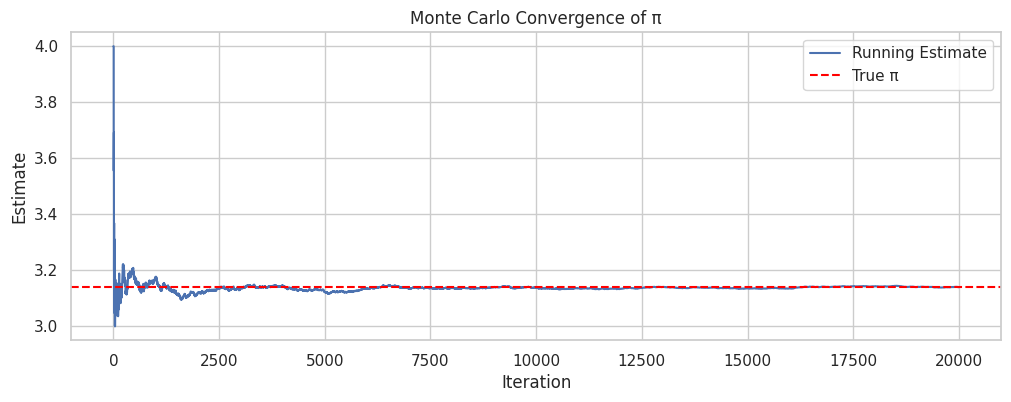

In [4]:
# ============================================================
# Visualization: Convergence of π estimate over iterations
# ============================================================

running_pi = 4 * np.cumsum(results) / np.arange(1, N+1)

plt.figure(figsize=(12,4))
plt.plot(running_pi, label="Running Estimate")
plt.axhline(np.pi, color="red", linestyle="--", label="True π")
plt.title("Monte Carlo Convergence of π")
plt.xlabel("Iteration")
plt.ylabel("Estimate")
plt.legend()
plt.show()

# -----------------------------------------
EXPERIMENT 2: RISK ANALYSIS USING MONTE CARLO
-----------------------------------------

## Scenario

A business makes uncertain daily profit modeled as a normal random variable:

$$
\text{profit} \sim \mathcal{N}(\mu = 500,\ \sigma = 120)
$$

**Goal:** Estimate the probability of a loss and the expected monthly performance using Monte Carlo simulation.


In [5]:
# ============================================================
# 4. BUSINESS RISK SIMULATION
# ============================================================

mu = 500
sigma = 120

def simulate_profit():
    return np.random.normal(mu, sigma)

N = 50000
profits = monte_carlo_simulation(simulate_profit, N)

loss_probability = (profits < 0).mean()
expected_monthly = profits.mean() * 30

loss_probability, expected_monthly

(np.float64(6e-05), np.float64(14989.173407997592))

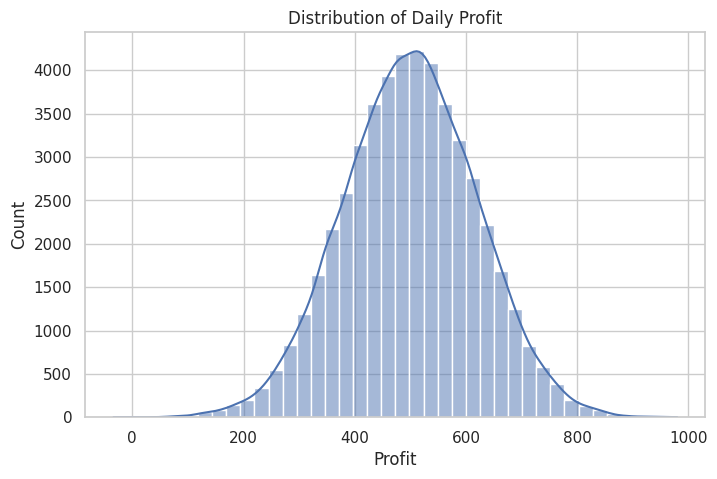

In [6]:
# ============================================================
# Visualization: Distribution of Simulated Profits
# ============================================================

plt.figure(figsize=(8,5))
sns.histplot(profits, bins=40, kde=True)
plt.title("Distribution of Daily Profit")
plt.xlabel("Profit")
plt.show()

# -----------------------------------------
EXPERIMENT 3: OPTION PRICING USING MONTE CARLO  
Black–Scholes Monte Carlo
-----------------------------------------

## Model

We simulate the terminal stock price under the Black–Scholes model:

$$
S_T = S_0 \exp\left( \left( \mu - \frac{\sigma^2}{2} \right) T + \sigma \sqrt{T}\, Z \right),
$$

where:

- \( S_0 \): initial stock price  
- \( S_T \): stock price at maturity \( T \)  
- \( \mu \): drift (expected return)  
- \( \sigma \): volatility  
- \( Z \sim \mathcal{N}(0,1) \): standard normal random variable  

The payoff of a European call option with strike \( K \) is:

$$
\text{Call Payoff} = \max(S_T - K,\ 0).
$$


In [7]:
# ============================================================
# 5. OPTION PRICING WITH MONTE CARLO
# ============================================================

S0 = 100      # initial stock price
K = 105       # strike price
r = 0.03      # risk-free rate
sigma = 0.25  # volatility
T = 1         # maturity in years

def simulate_call_option():
    Z = np.random.normal()
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoff = max(ST - K, 0)
    return np.exp(-r*T) * payoff

N = 100000
call_prices = monte_carlo_simulation(simulate_call_option, N)

call_estimate = call_prices.mean()
call_estimate

np.float64(9.074937619567562)

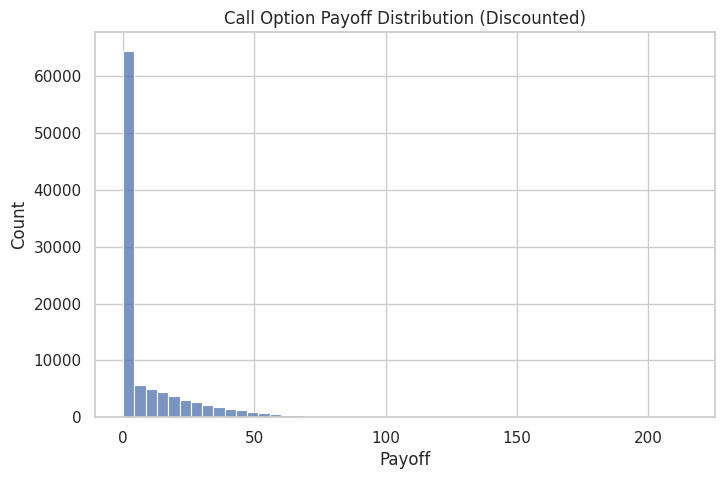

In [8]:
# ============================================================
# Visualization: Payoff Distribution
# ============================================================

plt.figure(figsize=(8,5))
sns.histplot(call_prices, bins=50)
plt.title("Call Option Payoff Distribution (Discounted)")
plt.xlabel("Payoff")
plt.show()

# -----------------------------------------
EXPERIMENT 4: CONFIDENCE INTERVALS FOR MONTE CARLO RESULTS
-----------------------------------------

We are often interested not only in a single Monte Carlo estimate, but also in how **uncertain** that estimate is.

Given a Monte Carlo estimator \( \hat{\theta} \) computed from \( N \) samples, and an empirical standard deviation \( s \), an approximate \( (1 - \alpha) \times 100\% \) confidence interval is:

$$
\hat{\theta} \ \pm \ z_{1 - \alpha/2} \cdot \frac{s}{\sqrt{N}},
$$

where \( z_{1 - \alpha/2} \) is the quantile of the standard normal distribution corresponding to the desired confidence level (e.g., \( z_{0.975} \approx 1.96 \) for a 95% confidence interval).


In [9]:
# ============================================================
# 6. CONFIDENCE INTERVAL CALCULATION
# ============================================================

def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    z = norm.ppf((1 + confidence) / 2)
    margin = z * std / np.sqrt(len(data))
    return mean - margin, mean + margin

pi_ci = confidence_interval(4 * results)
call_ci = confidence_interval(call_prices)

pi_ci, call_ci

((np.float64(3.1166198231655855), np.float64(3.162180176834415)),
 (np.float64(8.973918864657472), np.float64(9.175956374477652)))

# -----------------------------------------
EXPERIMENT 5: FULL MONTE CARLO FRAMEWORK CLASS
-----------------------------------------

A general Monte Carlo framework allows reusable workflows for:

1. Defining a simulation model  
2. Generating random samples  
3. Computing estimators  
4. Measuring uncertainty  
5. Producing confidence intervals  

A generic structure for a Monte Carlo simulation class can be represented mathematically as follows.

Given a model function:

$$
X = f(Z),
$$

where  
\( Z \sim p(z) \) is a source of randomness and  
\( X \) is the simulated output,

the Monte Carlo estimator for a quantity \( \theta = \mathbb{E}[X] \) is:

$$
\hat{\theta} = \frac{1}{N} \sum_{i=1}^{N} X_i.
$$

The empirical variance is:

$$
\hat{\sigma}^2 = \frac{1}{N - 1} \sum_{i=1}^{N} (X_i - \hat{\theta})^2.
$$

A \( 95\% \) confidence interval for \( \theta \) is:

$$
\hat{\theta} \pm 1.96 \cdot \frac{\hat{\sigma}}{\sqrt{N}}.
$$

Such a class can be extended to support:

- Vectorized simulations  
- Multiple estimators  
- Variance reduction techniques (e.g., antithetic sampling, control variates)  
- Parallelized Monte Carlo  
- Plotting and diagnostics  

This provides a complete, modular system for running any Monte Carlo experiment efficiently.


In [10]:
# ============================================================
# 7. OOP FRAMEWORK FOR MONTE CARLO PROJECT
# ============================================================

class MonteCarloEngine:
    def __init__(self, simulation_fn, n_sim=10000):
        self.simulation_fn = simulation_fn
        self.n_sim = n_sim
        self.results = None

    def run(self):
        self.results = monte_carlo_simulation(self.simulation_fn, self.n_sim)
        return self.results

    def mean(self):
        return np.mean(self.results)

    def var(self):
        return np.var(self.results)

    def ci(self, confidence=0.95):
        return confidence_interval(self.results, confidence)

# Example: use the framework to estimate π
engine = MonteCarloEngine(simulate_pi, 20000)
engine.run()
engine.mean() * 4

np.float64(3.1462)

# -----------------------------------------
EXPERIMENT 6: VISUALIZING MANY MONTE CARLO TRAJECTORIES
-----------------------------------------

Monte Carlo simulations often generate **entire trajectories** of a stochastic process rather than single values.  
For a stochastic process \( S_t \), we simulate paths:

$$
S_{t+\Delta t} = S_t \, g(Z_t),
$$

where  
\( g(\cdot) \) encodes the dynamics (e.g., geometric Brownian motion) and  
\( Z_t \sim \mathcal{N}(0,1) \) or another noise distribution.

For example, in geometric Brownian motion (GBM):

$$
S_{t+\Delta t} = S_t \exp\left( \left( \mu - \frac{\sigma^2}{2} \right)\Delta t + \sigma\sqrt{\Delta t}\, Z_t \right).
$$

Visualizing many such trajectories illustrates:

- The spread of uncertainty  
- The growth or decay trend  
- Volatility effects  
- Extreme outcomes  
- Probabilistic envelopes of the process  

Plotting dozens or hundreds of paths provides intuition about **risk**, **variance**, and **possible future scenarios**, which is essential in finance, forecasting, physics, reinforcement learning, and Bayesian modeling.


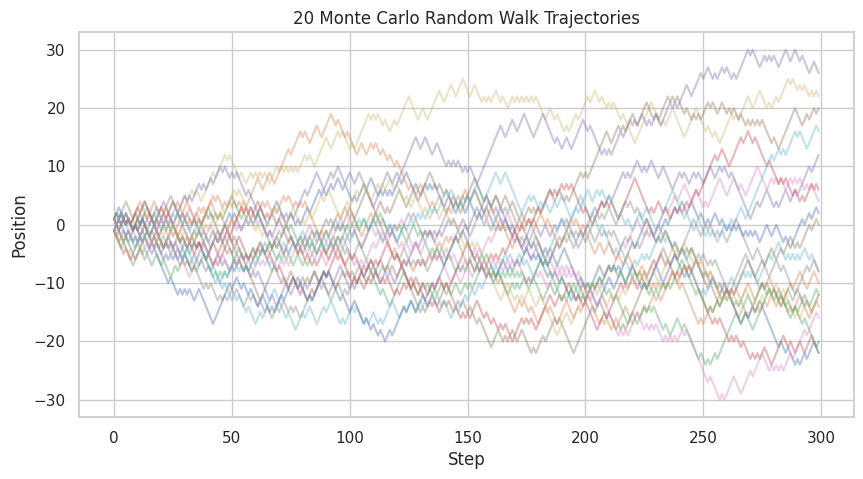

In [11]:
# ============================================================
# 8. RANDOM WALKS USING MONTE CARLO
# ============================================================

def random_walk(n_steps=200):
    steps = np.random.choice([-1, 1], size=n_steps)
    return np.cumsum(steps)

plt.figure(figsize=(10,5))
for _ in range(20):
    plt.plot(random_walk(300), alpha=0.4)
plt.title("20 Monte Carlo Random Walk Trajectories")
plt.xlabel("Step")
plt.ylabel("Position")
plt.show()

# -----------------------------------------
PROJECT SUMMARY
-----------------------------------------

This notebook demonstrated the core components and applications of Monte Carlo simulation, including:

- A reusable Monte Carlo engine  
- Estimating \( \pi \) using random sampling  
- Business risk simulation with probabilistic profit models  
- Option pricing via Monte Carlo under the Black–Scholes framework  
- Random walk and stochastic process trajectory visualization  
- Construction of confidence intervals for Monte Carlo estimates  
- A modular, object-oriented Monte Carlo framework suitable for extension and real-world applications  
